In [1]:
import sys
MODULE_FULL_PATH = './src/'
sys.path.insert(1, MODULE_FULL_PATH)

from model import *
from pdr import *
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import tensorflow as tf
from data_loader import load_data, preprocess 
from utils import iterative_optimize
from metrics import lateness, makespan, count_setup_changes
import numpy as np
import os 
import yaml
import json

In [2]:
print('TF version {}'.format(tf.__version__))

config_path = 'config.yaml'
with open(config_path, 'r') as stream:
    config_param = yaml.safe_load(stream)

TF version 2.3.1


In [3]:
x, y = load_data(config_param.get('x_path'), config_param.get('y_path'))
data_train, data_val, data_test, data_properties = preprocess(x, y, 1, config_param.get('split'))

100%|██████████| 5000/5000 [00:02<00:00, 2390.95it/s]


In [4]:
ckpt_path = os.path.join(config_param.get('checkpoint_path'), 'cp-0000.h5')
model_path = os.path.join(config_param.get('model_path'), 'model' + config_param.get('model_format'))
model_config_path = os.path.join(config_param.get('model_path'), 'model_config.json')

print('Loading {} ...'.format(ckpt_path))

with open(model_config_path, 'r+') as f:
    model_config = json.load(f)
    
custom_objects = {
    'SchedulingModel': SchedulingModel,
    'PointWiseFeedForwardNetwork': PointWiseFeedForwardNetwork,
    'EncoderLayer': EncoderLayer,
    'MaschineStateEmbedding': MaschineStateEmbedding,
    'JobEmbedding': JobEmbedding
}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.model_from_json(model_config)

model.load_weights(ckpt_path)

print('Done.')

Loading ckpts/cp-0000.h5 ...
Done.


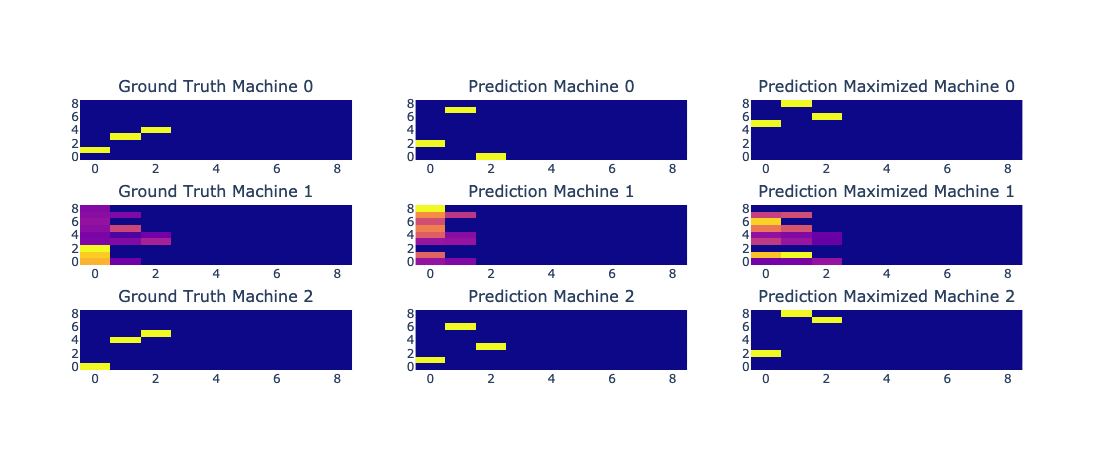

In [21]:
x, true = next(data_test)

output = iterative_optimize(optimizer=None,
                            model=model,
                            x=x,
                            y_true=y_true,
                            data_properties=data_properties,
                            training=False)
total_loss, grads, y_pred, m, [jq_emb, ms_emb], attn = output

high_level_titles = ['Ground Truth', 'Prediction', 'Prediction Maximized']
titles = [high_level_titles[i]+' Machine '+str(m) for m in range(3) for i in range(3)]

fig = make_subplots(rows=3, cols=3, subplot_titles=(titles))

for i, y in enumerate([y_true, y_pred, y_pred_max]):
    for m in range(3):
        fig.add_trace(
            go.Heatmap(
                z=y[0][m],
                x=np.arange(8, -1),
                y=np.arange(8, -1),
                showscale=False
            ),
            row=i+1, col=m+1
        )
fig.show()

In [22]:
ms_true_total = []
ms_pred_total = []
ms_rnd_total = []
ms_edd_total = []
ms_spt_total = []

ln_true_total = []
ln_pred_total = []
ln_rnd_total = []
ln_edd_total = []
ln_spt_total = []

steps_per_epoch = 10
for batch, (x, y_true) in enumerate(data_test):
    if batch >= steps_per_epoch:
        break
    output = iterative_optimize(optimizer=None,
                                model=model,
                                x=x,
                                y_true=y_true,
                                data_properties=data_properties,
                                training=False)
    total_loss, grads, y_pred, m, [jq_emb, ms_emb], attn = output

    y_pred_max = y_pred.numpy()
    for m in range(3):
        for t in range(9):
            if np.sum(y_pred_max[:, m, :, t]) != 0.0:
                idx = tf.math.argmax(y_pred[:, m, :, t], axis=-1)
                idx = tf.cast(idx, tf.int32)
                y_pred_max[:, m, :, t] = tf.one_hot(idx, 9)

    ms_true_total.append(makespan(x, y_true))
    ms_pred_total.append(makespan(x, y_pred_max))
    ms_rnd_total.append(makespan(x, random_sample()))
    ms_edd_total.append(makespan(x, edd(x)))
    ms_spt_total.append(makespan(x, spt(x)))

    ln_true_total.append(lateness(x, y_true))
    ln_pred_total.append(lateness(x, y_pred_max))
    ln_rnd_total.append(lateness(x, random_sample()))
    ln_edd_total.append(lateness(x, edd(x)))
    ln_spt_total.append(lateness(x, spt(x)))

true: mean 109.4000015258789, stdd 8.946507453918457
pred: mean 129.3000030517578, stdd 17.181676864624023
random: mean 180.1999969482422, stdd 35.17897033691406
edd: mean 118.19999694824219, stdd 9.042123794555664
spt: mean 120.0999984741211, stdd 7.13372278213501


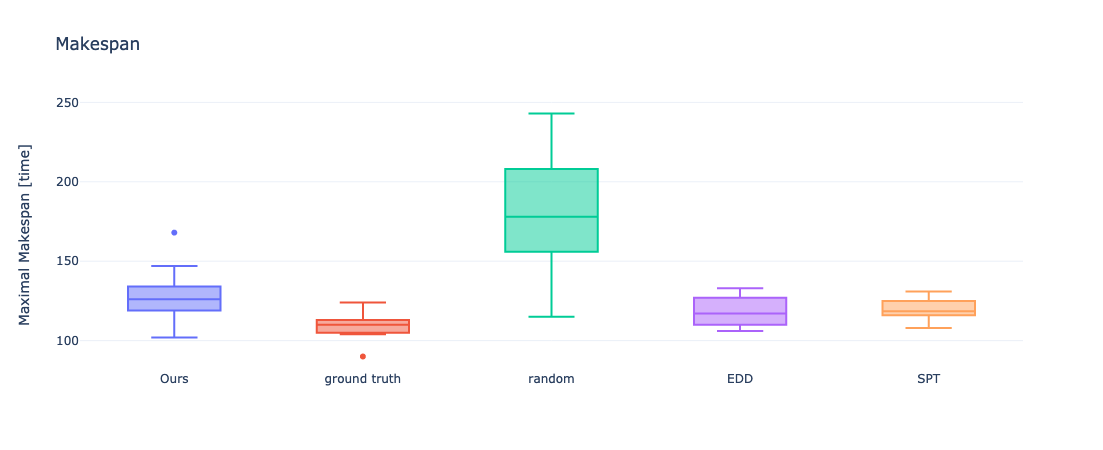

In [23]:
ms_true_total_max = np.amax(ms_true_total, axis=-1)
ms_pred_total_max = np.amax(ms_pred_total, axis=-1)
ms_rnd_total_max = np.amax(ms_rnd_total, axis=-1)
ms_edd_total_max = np.amax(ms_edd_total, axis=-1)
ms_spt_total_max = np.amax(ms_spt_total, axis=-1)

print('true: mean {0}, stdd {1}'.format(
    np.mean(ms_true_total_max), np.std(ms_true_total_max)))
print('pred: mean {0}, stdd {1}'.format(
    np.mean(ms_pred_total_max), np.std(ms_pred_total_max)))
print('random: mean {0}, stdd {1}'.format(
    np.mean(ms_rnd_total_max), np.std(ms_rnd_total_max)))
print('edd: mean {0}, stdd {1}'.format(
    np.mean(ms_edd_total_max), np.std(ms_edd_total_max)))
print('spt: mean {0}, stdd {1}'.format(
    np.mean(ms_spt_total_max), np.std(ms_spt_total_max)))

fig = go.Figure()
fig.add_trace(go.Box(y=ms_pred_total_max[:, 0], name="Ours"))
fig.add_trace(go.Box(y=ms_true_total_max[:, 0], name="ground truth"))
fig.add_trace(go.Box(y=ms_rnd_total_max[:, 0], name="random"))
fig.add_trace(go.Box(y=ms_edd_total_max[:, 0], name="EDD"))
fig.add_trace(go.Box(y=ms_spt_total_max[:, 0], name="SPT"))
fig.update_layout(showlegend=False, title="Makespan", template="plotly_white")
fig.update_yaxes(title_text='Maximal Makespan [time]')

fig.show()

true: mean -464.5, stdd 47.00478744506836
pred: mean -402.20001220703125, stdd 64.21495056152344
random: mean -284.70001220703125, stdd 107.8313980102539
edd: mean -420.8999938964844, stdd 54.68354415893555
spt: mean -438.70001220703125, stdd 43.1533317565918


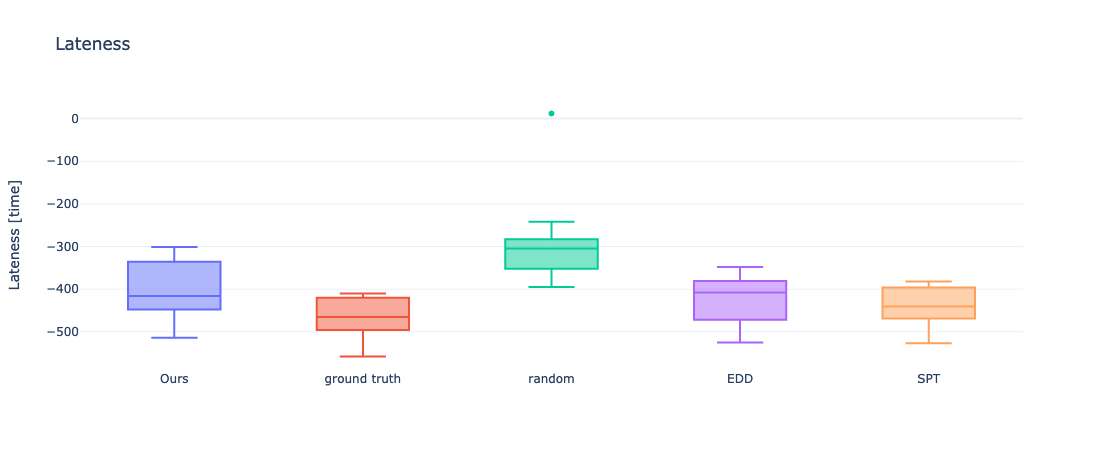

In [24]:
ln_true_total_max = np.array(ln_true_total)
ln_pred_total_max = np.array(ln_pred_total)
ln_rnd_total_max = np.array(ln_rnd_total)
ln_edd_total_max = np.array(ln_edd_total)
ln_spt_total_max = np.array(ln_spt_total)

print('true: mean {0}, stdd {1}'.format(
    np.mean(ln_true_total_max), np.std(ln_true_total_max)))
print('pred: mean {0}, stdd {1}'.format(
    np.mean(ln_pred_total_max), np.std(ln_pred_total_max)))
print('random: mean {0}, stdd {1}'.format(
    np.mean(ln_rnd_total_max), np.std(ln_rnd_total_max)))
print('edd: mean {0}, stdd {1}'.format(
    np.mean(ln_edd_total_max), np.std(ln_edd_total_max)))
print('spt: mean {0}, stdd {1}'.format(
    np.mean(ln_spt_total_max), np.std(ln_spt_total_max)))

fig = go.Figure()
fig.add_trace(go.Box(y=ln_pred_total_max, name="Ours"))
fig.add_trace(go.Box(y=ln_true_total_max, name="ground truth"))
fig.add_trace(go.Box(y=ln_rnd_total_max, name="random"))
fig.add_trace(go.Box(y=ln_edd_total_max, name="EDD"))
fig.add_trace(go.Box(y=ln_spt_total_max, name="SPT"))
fig.update_layout(showlegend=False, title="Lateness", template="plotly_white")
fig.update_yaxes(title_text='Lateness [time]')

fig.show()